## Import Necessary Libraries

In [6]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics

## Data Directory

In [7]:
train_dir = 'split/train'
train_NORMAL_dir = 'split/train/NORMAL/'
train_PNEUMONIA_dir = 'split/train/PNEUMONIA/'

validation_dir = 'split/validation'
validation_NORMAL_dir = 'split/validation/NORMAL/'
validation_PNEUMONIA_dir = 'split/validation/PNEUMONIA/'

test_dir = 'split/test'
test_NORMAL_dir = 'split/test/NORMAL/'
test_PNEUMONIA_dir = 'split/test/PNEUMONIA/'

## Function for results visualization

In [8]:
def create_charts(cnn, cnn_model):
    """
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

## Model 1 Baseline: Convolution Layer = 1, Dense = 32, Epochs = 30, No Data Augmentation

In [11]:
def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    """
    make function for data generator
    """
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (64,64),
                                         batch_size = 128,
                                         color_mode = 'grayscale',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [12]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)
    


Found 4099 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [13]:
# Design the model

cnn = Sequential()

cnn.add(InputLayer(input_shape=(64, 64, 1)))
cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))


cnn.add(Flatten())

cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

# Complie
cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [14]:
# Train the model
# fit not fit_generator

cnn_model = cnn.fit(train_generator,
                    epochs = 30,
                    steps_per_epoch = len(train_generator),
                    validation_data = val_generator,
                    validation_steps = len(val_generator),
                    verbose = 1)

Epoch 1/30
33/33 [==============================] - 26s 779ms/step - loss: 0.7201 - acc: 0.6274 - val_loss: 0.3162 - val_acc: 0.9147
Epoch 2/30
33/33 [==============================] - 24s 738ms/step - loss: 0.2802 - acc: 0.9006 - val_loss: 0.2018 - val_acc: 0.9369
Epoch 3/30
33/33 [==============================] - 24s 738ms/step - loss: 0.1935 - acc: 0.9290 - val_loss: 0.1967 - val_acc: 0.9326
Epoch 4/30
33/33 [==============================] - 24s 745ms/step - loss: 0.1715 - acc: 0.9316 - val_loss: 0.1464 - val_acc: 0.9471
Epoch 5/30
33/33 [==============================] - 24s 741ms/step - loss: 0.1471 - acc: 0.9433 - val_loss: 0.2710 - val_acc: 0.8823
Epoch 6/30
33/33 [==============================] - 24s 737ms/step - loss: 0.1873 - acc: 0.9273 - val_loss: 0.1433 - val_acc: 0.9497
Epoch 7/30
33/33 [==============================] - 24s 736ms/step - loss: 0.1271 - acc: 0.9527 - val_loss: 0.1442 - val_acc: 0.9488
Epoch 8/30
33/33 [==============================] - 24s 739ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 95.56% | Precision = 96.74% | Recall = 97.19% | Specificity = 91.14% | F1 Score = 96.96%


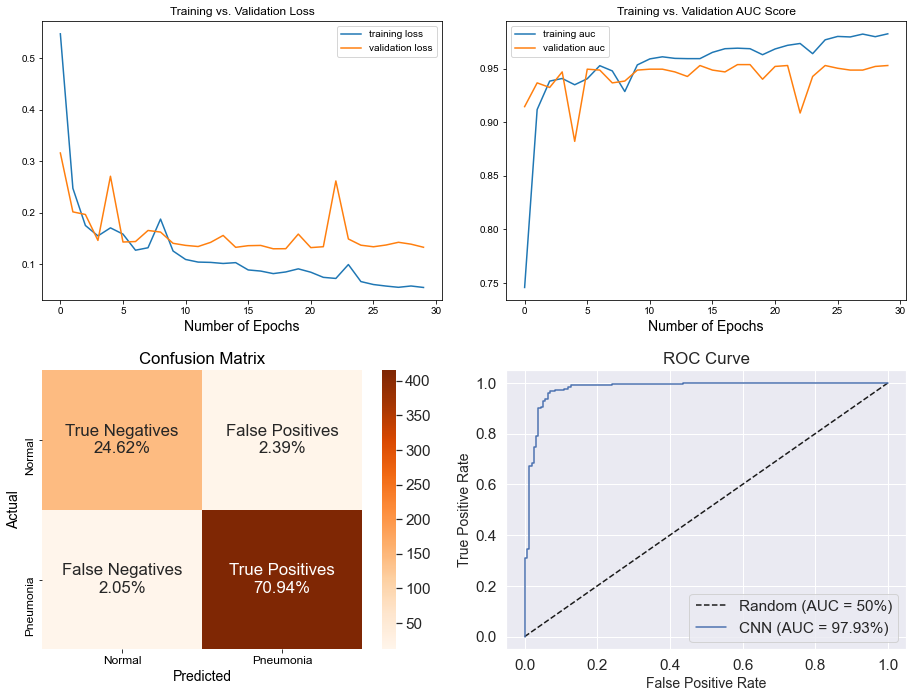

In [15]:
# Plot 

create_charts(cnn, cnn_model)

## Model 2: Convolution Layers = 3, Dense = 64, Epochs = 100, Data Augmentation

In [13]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 4099 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [27]:
def build_model_1():
    
    # Design the model
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn = build_model_1()

In [15]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
33/33 [==============================] - 25s 755ms/step - loss: 0.6094 - acc: 0.7257 - val_loss: 0.5250 - val_acc: 0.7295
Epoch 2/100
33/33 [==============================] - 24s 731ms/step - loss: 0.4704 - acc: 0.7730 - val_loss: 0.4117 - val_acc: 0.8217
Epoch 3/100
33/33 [==============================] - 24s 727ms/step - loss: 0.3748 - acc: 0.8442 - val_loss: 0.2993 - val_acc: 0.8788
Epoch 4/100
33/33 [==============================] - 24s 725ms/step - loss: 0.2962 - acc: 0.8705 - val_loss: 0.2220 - val_acc: 0.9130
Epoch 5/100
33/33 [==============================] - 24s 720ms/step - loss: 0.3201 - acc: 0.8591 - val_loss: 0.2957 - val_acc: 0.8524
Epoch 6/100
33/33 [==============================] - 24s 729ms/step - loss: 0.3013 - acc: 0.8740 - val_loss: 0.2058 - val_acc: 0.9181
Epoch 7/100
33/33 [==============================] - 24s 724ms/step - loss: 0.2837 - acc: 0.8765 - val_loss: 0.2191 - val_acc: 0.9113
Epoch 8/100
33/33 [==============================] - 24s 742ms

Epoch 62/100
33/33 [==============================] - 24s 719ms/step - loss: 0.1763 - acc: 0.9342 - val_loss: 0.1476 - val_acc: 0.9428
Epoch 63/100
33/33 [==============================] - 24s 716ms/step - loss: 0.1357 - acc: 0.9551 - val_loss: 0.1535 - val_acc: 0.9480
Epoch 64/100
33/33 [==============================] - 23s 702ms/step - loss: 0.1469 - acc: 0.9406 - val_loss: 0.1521 - val_acc: 0.9445
Epoch 65/100
33/33 [==============================] - 23s 707ms/step - loss: 0.1282 - acc: 0.9545 - val_loss: 0.1625 - val_acc: 0.9309
Epoch 66/100
33/33 [==============================] - 24s 737ms/step - loss: 0.1409 - acc: 0.9457 - val_loss: 0.1544 - val_acc: 0.9480
Epoch 67/100
33/33 [==============================] - 24s 718ms/step - loss: 0.1315 - acc: 0.9499 - val_loss: 0.1796 - val_acc: 0.9249
Epoch 68/100
33/33 [==============================] - 24s 739ms/step - loss: 0.1253 - acc: 0.9535 - val_loss: 0.1437 - val_acc: 0.9514
Epoch 69/100
33/33 [==============================] - 2

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 95.21% | Precision = 96.94% | Recall = 96.49% | Specificity = 91.77% | F1 Score = 96.71%


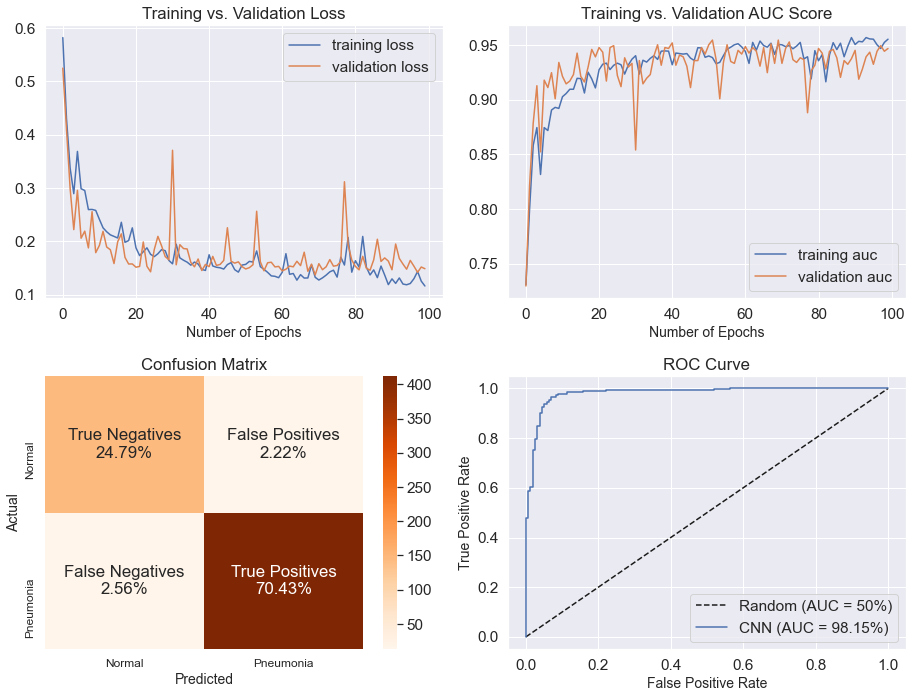

In [16]:
# Plot 

create_charts(cnn, cnn_model)

## Model 3: Convolution Layers = 3, Dense = 128, Epochs = 100, Data Augmentation

In [29]:
# Design the model
def build_model_2():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(64, 64, 1)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(32, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))

    # Compile

    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

In [30]:
cnn = build_model_2()

In [19]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
33/33 [==============================] - 25s 745ms/step - loss: 0.6198 - acc: 0.6745 - val_loss: 0.5560 - val_acc: 0.7295
Epoch 2/100
33/33 [==============================] - 23s 706ms/step - loss: 0.5156 - acc: 0.7394 - val_loss: 0.3293 - val_acc: 0.8788
Epoch 3/100
33/33 [==============================] - 23s 712ms/step - loss: 0.3965 - acc: 0.8206 - val_loss: 0.2908 - val_acc: 0.8874
Epoch 4/100
33/33 [==============================] - 23s 711ms/step - loss: 0.3106 - acc: 0.8657 - val_loss: 0.2637 - val_acc: 0.8857
Epoch 5/100
33/33 [==============================] - 23s 706ms/step - loss: 0.3468 - acc: 0.8412 - val_loss: 0.2896 - val_acc: 0.8712
Epoch 6/100
33/33 [==============================] - 23s 705ms/step - loss: 0.2741 - acc: 0.8811 - val_loss: 0.3878 - val_acc: 0.8200
Epoch 7/100
33/33 [==============================] - 23s 707ms/step - loss: 0.2706 - acc: 0.8836 - val_loss: 0.2062 - val_acc: 0.9258
Epoch 8/100
33/33 [==============================] - 23s 705ms

Epoch 62/100
33/33 [==============================] - 23s 706ms/step - loss: 0.1482 - acc: 0.9413 - val_loss: 0.1414 - val_acc: 0.9514
Epoch 63/100
33/33 [==============================] - 23s 707ms/step - loss: 0.1235 - acc: 0.9541 - val_loss: 0.1375 - val_acc: 0.9514
Epoch 64/100
33/33 [==============================] - 25s 772ms/step - loss: 0.1187 - acc: 0.9581 - val_loss: 0.1494 - val_acc: 0.9471
Epoch 65/100
33/33 [==============================] - 23s 705ms/step - loss: 0.1187 - acc: 0.9543 - val_loss: 0.1319 - val_acc: 0.9539
Epoch 66/100
33/33 [==============================] - 1345s 42s/step - loss: 0.1071 - acc: 0.9604 - val_loss: 0.1378 - val_acc: 0.9497
Epoch 67/100
33/33 [==============================] - 25s 755ms/step - loss: 0.1188 - acc: 0.9572 - val_loss: 0.1371 - val_acc: 0.9505
Epoch 68/100
33/33 [==============================] - 24s 717ms/step - loss: 0.1305 - acc: 0.9485 - val_loss: 0.1896 - val_acc: 0.9215
Epoch 69/100
33/33 [==============================] - 2

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 94.87% | Precision = 96.49% | Recall = 96.49% | Specificity = 90.51% | F1 Score = 96.49%


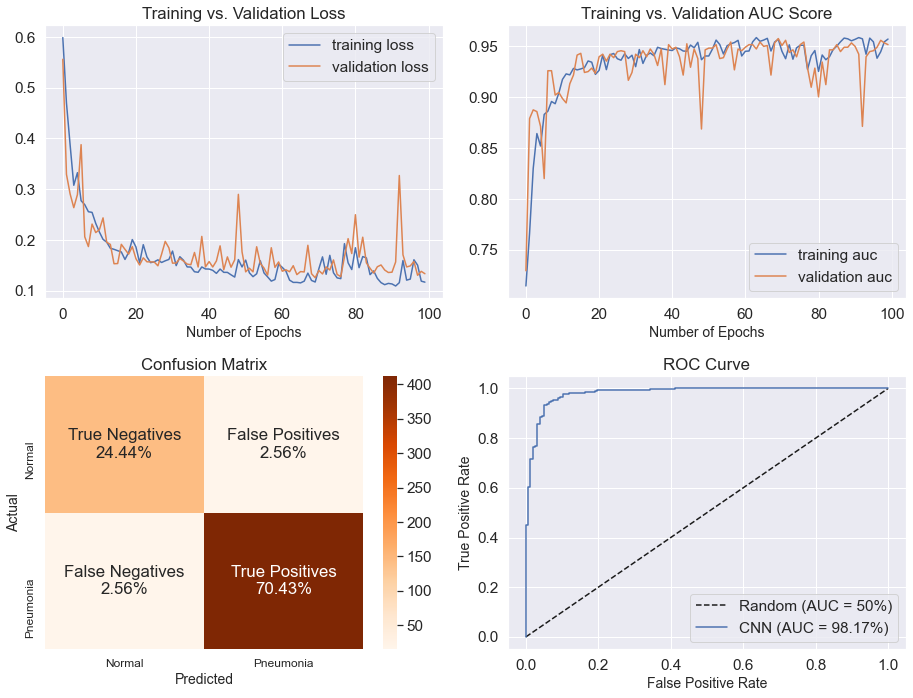

In [20]:
# Plot 

create_charts(cnn, cnn_model)

## Model 4: Convolution Layers = 3, Dense 128, Epochs = 200, Data Augmentation

In [23]:
# Train the model

cnn_model = cnn.fit_generator(train_generator,
                              epochs = 200,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
33/33 [==============================] - 23s 694ms/step - loss: 0.6142 - acc: 0.6679 - val_loss: 0.5408 - val_acc: 0.7295
Epoch 2/200
33/33 [==============================] - 22s 677ms/step - loss: 0.5027 - acc: 0.7443 - val_loss: 0.3005 - val_acc: 0.8899
Epoch 3/200
33/33 [==============================] - 22s 660ms/step - loss: 0.3615 - acc: 0.8376 - val_loss: 0.3232 - val_acc: 0.8797
Epoch 4/200
33/33 [==============================] - 22s 658ms/step - loss: 0.3620 - acc: 0.8377 - val_loss: 0.3266 - val_acc: 0.8601
Epoch 5/200
33/33 [==============================] - 22s 660ms/step - loss: 0.3335 - acc: 0.8610 - val_loss: 0.2471 - val_acc: 0.9036
Epoch 6/200
33/33 [==============================] - 22s 660ms/step - loss: 0.2714 - acc: 0.8843 - val_loss: 0.2689 - val_acc: 0.8899
Epoch 7/200
33/33 [==============================] - 22s 677ms/step - loss: 0.3449 - acc: 0.8394 - val_loss: 0.2340 - val_acc: 0.9002
Epoch 8/200
33/33 [==============================] - 22s 660ms

Epoch 62/200
33/33 [==============================] - 22s 658ms/step - loss: 0.1294 - acc: 0.9469 - val_loss: 0.1480 - val_acc: 0.9514
Epoch 63/200
33/33 [==============================] - 22s 662ms/step - loss: 0.1751 - acc: 0.9319 - val_loss: 0.1373 - val_acc: 0.9514
Epoch 64/200
33/33 [==============================] - 22s 659ms/step - loss: 0.1267 - acc: 0.9511 - val_loss: 0.1290 - val_acc: 0.9548
Epoch 65/200
33/33 [==============================] - 22s 659ms/step - loss: 0.1139 - acc: 0.9586 - val_loss: 0.1324 - val_acc: 0.9488
Epoch 66/200
33/33 [==============================] - 22s 661ms/step - loss: 0.1150 - acc: 0.9582 - val_loss: 0.1499 - val_acc: 0.9445
Epoch 67/200
33/33 [==============================] - 22s 658ms/step - loss: 0.1172 - acc: 0.9549 - val_loss: 0.1465 - val_acc: 0.9531
Epoch 68/200
33/33 [==============================] - 22s 659ms/step - loss: 0.1547 - acc: 0.9459 - val_loss: 0.1354 - val_acc: 0.9539
Epoch 69/200
33/33 [==============================] - 2

33/33 [==============================] - 23s 704ms/step - loss: 0.1105 - acc: 0.9575 - val_loss: 0.1483 - val_acc: 0.9454
Epoch 183/200
33/33 [==============================] - 23s 704ms/step - loss: 0.0800 - acc: 0.9691 - val_loss: 0.1297 - val_acc: 0.9556
Epoch 184/200
33/33 [==============================] - 23s 706ms/step - loss: 0.0641 - acc: 0.9796 - val_loss: 0.1225 - val_acc: 0.9573
Epoch 185/200
33/33 [==============================] - 23s 708ms/step - loss: 0.0700 - acc: 0.9712 - val_loss: 0.1404 - val_acc: 0.9497
Epoch 186/200
33/33 [==============================] - 24s 715ms/step - loss: 0.0720 - acc: 0.9725 - val_loss: 0.1258 - val_acc: 0.9548
Epoch 187/200
33/33 [==============================] - 23s 703ms/step - loss: 0.0559 - acc: 0.9792 - val_loss: 0.1279 - val_acc: 0.9505
Epoch 188/200
33/33 [==============================] - 23s 711ms/step - loss: 0.0720 - acc: 0.9771 - val_loss: 0.1516 - val_acc: 0.9462
Epoch 189/200
33/33 [==============================] - 23s 703

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 94.19% | Precision = 98.04% | Recall = 93.91% | Specificity = 94.94% | F1 Score = 95.93%


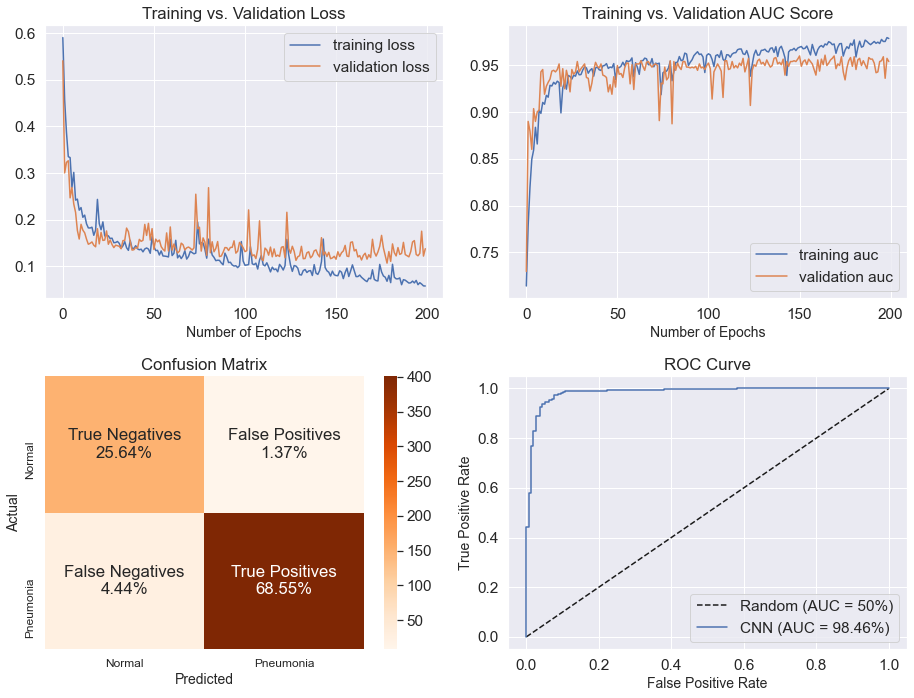

In [24]:
# Plot 

create_charts(cnn, cnn_model)